# Library

In [1]:
import random
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from rdkit import DataStructs
from rdkit.Chem import PandasTools, AllChem, Descriptors
import scipy

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from xgboost import XGBRegressor

import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

import logging
optuna_logger = logging.getLogger('optuna')
optuna_logger.setLevel(logging.CRITICAL)

# Parameter

In [2]:
electron_affinities = {
    'Br':324.6,
    'Se':79.9,
    'se':79.9,
    'I':126.9,
    'H': 72.8,
    'Li': 59.6,
    'Be': -48,
    'B': 26.7,
    'C': 121.8,
    'c': 121.8,
    'N': 7.0,
    'O': 140.4,
    'o': 140.4,
    'F': 328.0,
    'Na': 52.8,
    'Mg': -40,
    'Al': 42.5,
    'Si': 134.1,
    'P': 72.0,
    'S': 200.0,
    's': 200.0,
    'Cl': 349.0
}

wtd_electron_affinities = {
    'Br':324.6,
    'Se':79.9,
    'I':126.9,
    'H': 72.8,
    'Li': 59.6,
    'Be': -48,
    'B': 26.7,
    'C': 121.8,
    'N': 7.0,
    'O': 140.4,
    'F': 328.0,
    'Na': 52.8,
    'Mg': -40,
    'Al': 42.5,
    'Si': 134.1,
    'P': 72.0 * 1.2,
    'S': 200.0 * 1.5,
    'Cl': 349.0
}

element_properties = {
    'Br':{'Atomic_weight': 79.904, 'Natural_abundance': 50.69},
    'Se':{'Atomic_weight': 78.96, 'Natural_abundance': 49.61},
    'se':{'Atomic_weight': 78.96, 'Natural_abundance': 49.61},
    'I':{'Atomic_weight': 126.904, 'Natural_abundance': 100},
    'H': {'Atomic_weight': 1.008, 'Natural_abundance': 99.985},
    'Li': {'Atomic_weight': 6.94, 'Natural_abundance': 92.58},
    'Be': {'Atomic_weight': 9.012, 'Natural_abundance': 100},
    'B': {'Atomic_weight': 10.81, 'Natural_abundance': 80.1},
    'C': {'Atomic_weight': 12.011, 'Natural_abundance': 98.93},
    'c': {'Atomic_weight': 12.011, 'Natural_abundance': 98.93},
    'N': {'Atomic_weight': 14.007, 'Natural_abundance': 99.63},
    'O': {'Atomic_weight': 15.999, 'Natural_abundance': 99.76},
    'o': {'Atomic_weight': 15.999, 'Natural_abundance': 99.76},
    'F': {'Atomic_weight': 18.998, 'Natural_abundance': 100},
    'Na': {'Atomic_weight': 22.990, 'Natural_abundance': 100},
    'Mg': {'Atomic_weight': 24.305, 'Natural_abundance': 78.99},
    'Al': {'Atomic_weight': 26.982, 'Natural_abundance': 100},
    'Si': {'Atomic_weight': 28.085, 'Natural_abundance': 92.23},
    'P': {'Atomic_weight': 30.974, 'Natural_abundance': 100},
    'S': {'Atomic_weight': 32.06, 'Natural_abundance': 95.02},
    's': {'Atomic_weight': 32.06, 'Natural_abundance': 95.02},
    'Cl': {'Atomic_weight': 35.45, 'Natural_abundance': 75.78},
}

# Function

In [84]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    
def mol2fp(mol):
    fp = AllChem.GetHashedMorganFingerprint(mol, 8, nBits=4096*2)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar

seed_everything(42) # Seed 고정


class CustomDataset(Dataset):
    def __init__(self, df, target):
        self.df = df
        self.target = target # HLM or MLM

        self.feature_select = transform
        self.fp = self.feature_select.fit_transform(np.stack(df['FPs']))

    def __getitem__(self, index):
        fp = self.fp[index]
        return torch.tensor(fp).float() # feature
        
    def __len__(self):
        return len(self.df)
    
def HLM_make_train_val(train1, val1):
    train1_y = train1["HLM"]
    train1_x = train1.iloc[:,4:]

    val1_y = val1["HLM"]
    val1_x = val1.iloc[:,4:]
    return train1_x, train1_y, val1_x, val1_y

def MLM_make_train_val(train1, val1):
    train1_y = train1["MLM"]
    train1_x = train1.iloc[:,4:]

    val1_y = val1["MLM"]
    val1_x = val1.iloc[:,4:]
    return train1_x, train1_y, val1_x, val1_y


def calculate_gasteiger_charges(molecule):
    AllChem.ComputeGasteigerCharges(molecule)
    charges = [float(atom.GetProp('_GasteigerCharge')) for atom in molecule.GetAtoms()]
    return charges

def calculate_affinities(mol):
    affinities = []
    for atom in mol.GetAtoms():
        symbol = atom.GetSymbol()
        affinity = electron_affinities.get(symbol, None)
        if affinity is not None:
            affinities.append(affinity)
    return affinities

def wtd_calculate_affinities(mol):
    affinities = []
    for atom in mol.GetAtoms():
        symbol = atom.GetSymbol()
        affinity = wtd_electron_affinities.get(symbol, None)
        if affinity is not None:
            affinities.append(affinity)
    return affinities

def calculate_range(affinities):
    return np.max(affinities) - np.min(affinities)

def wtd_calculate_average_atomic_mass(mol):
    average_atomic_mass = 0
    total_abundance = 0
    
    for atom in mol.GetAtoms():
        symbol = atom.GetSymbol()
        properties = element_properties.get(symbol, None)
        if properties is not None:
            atomic_weight = properties['Atomic_weight']
            natural_abundance = properties['Natural_abundance']

            average_atomic_mass += atomic_weight * (natural_abundance / 100)
            total_abundance += natural_abundance / 100

    if total_abundance != 0:
        average_atomic_mass /= total_abundance
        
    return average_atomic_mass

def make_feat(train):
    PandasTools.AddMoleculeColumnToFrame(train,'SMILES','Molecule')
    train["FPs"] = train.Molecule.apply(mol2fp)

    train["addH"] = train.Molecule.apply(AllChem.AddHs)
    train['Charges'] = train['addH'].apply(calculate_gasteiger_charges)

    train['affinities'] = train['Molecule'].apply(calculate_affinities)
    train['wtd_affinities'] = train['Molecule'].apply(wtd_calculate_affinities)

    train['mean_affinity'] = train['affinities'].apply(np.mean)
    train['gmean_affinity'] = train['affinities'].apply(scipy.stats.gmean)
    train["entropy_affinity"] = train['affinities'].apply(scipy.stats.entropy)
    train['range_affinity'] = train['affinities'].apply(calculate_range)
    train['std_affinity'] = train['affinities'].apply(np.std)

#     train['wtd_mean_affinity'] = train['wtd_affinities'].apply(np.mean)
#     train['wtd_gmean_affinity'] = train['wtd_affinities'].apply(scipy.stats.gmean)
#     train["wtd_entropy_affinity"] = train['wtd_affinities'].apply(scipy.stats.entropy)
#     train['wtd_range_affinity'] = train['wtd_affinities'].apply(calculate_range)
#     train['wtd_std_affinity'] = train['wtd_affinities'].apply(np.std)

    train['length'] = train['wtd_affinities'].apply(len)
    train = train.drop(['affinities', 'wtd_affinities'], axis = 1)

    train['GasteigerCharges'] = train['addH'].apply(calculate_gasteiger_charges)

#     train['charge_mean'] = train['GasteigerCharges'].apply(np.mean)
#     train['charge_gmean'] = train['GasteigerCharges'].apply(scipy.stats.gmean)
#     train["charge_entropy"] = train['GasteigerCharges'].apply(scipy.stats.entropy)
#     train['charge_range'] = train['GasteigerCharges'].apply(calculate_range)
#     train['charge_std'] = train['GasteigerCharges'].apply(np.std)

#     train['avg_Molecular_weight'] = train['Molecular_Weight']/train['length']
#     train['average_atomic_mass'] = train['Molecule'].apply(wtd_calculate_average_atomic_mass)

    train = train.drop(["addH",'Molecule', 'FPs','Charges', 'GasteigerCharges'], axis = 1)
    
    return train

def objective_xgb(trial,train1_x, train1_y, val1_x, val1_y,
                 train2_x, train2_y, val2_x, val2_y,
                 train3_x, train3_y, val3_x, val3_y,
                 train4_x, train4_y, val4_x, val4_y,
                 train5_x, train5_y, val5_x, val5_y):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000), 
        'max_depth': trial.suggest_int('max_depth',1, 60), 
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 60), 
        "colsample_bytree" : trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        "learning_rate" : trial.suggest_loguniform('learning_rate', 0.001, 0.99)            
    }
    model = XGBRegressor(**params,
                         #tree_method='gpu_hist',
                         nthread=16, n_jobs=16,
                         random_state=42)
    scores = []
    scores.append(get_score(model, train1_x, train1_y, val1_x, val1_y))
    scores.append(get_score(model, train2_x, train2_y, val2_x, val2_y))
    scores.append(get_score(model, train3_x, train3_y, val3_x, val3_y))
    scores.append(get_score(model, train4_x, train4_y, val4_x, val4_y))
    scores.append(get_score(model, train5_x, train5_y, val5_x, val5_y))
    
    mean_score = np.mean(scores)
    print(f"RMSE_MEAN = {mean_score}")
    return mean_score

def objective_rfc(trial,train1_x, train1_y, val1_x, val1_y,
                 train2_x, train2_y, val2_x, val2_y,
                 train3_x, train3_y, val3_x, val3_y,
                 train4_x, train4_y, val4_x, val4_y,
                 train5_x, train5_y, val5_x, val5_y):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 500), 
        'max_depth': trial.suggest_int('max_depth',1, 50), 
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 30),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50), 
    }
    model = RandomForestRegressor(**params,
                              random_state=42)
    scores = []
    scores.append(get_score(model, train1_x, train1_y, val1_x, val1_y))
    scores.append(get_score(model, train2_x, train2_y, val2_x, val2_y))
    scores.append(get_score(model, train3_x, train3_y, val3_x, val3_y))
    scores.append(get_score(model, train4_x, train4_y, val4_x, val4_y))
    scores.append(get_score(model, train5_x, train5_y, val5_x, val5_y))
    
    mean_score = np.mean(scores)
    print(f"RMSE_MEAN = {mean_score}")
    return mean_score

def get_score(model, train1_x, train1_y, val1_x, val1_y):
    model.fit(train1_x, train1_y)
    y_pred_1 = model.predict(val1_x)
    mse = mean_squared_error(val1_y, y_pred_1)
    rmse = np.sqrt(mse)
    return rmse

def count_s(real_train):
    return real_train.count("@@")
def count_r(real_train):
    return real_train.count("@")
def count_chiral(real_train):
    return real_train['s_form'] + real_train['r_form']

def cal_error(train1_x, train1_y, val1_x, val1_y, j, k):
    model_MLM = XGBRegressor(# tree_method='gpu_hist',
                             nthread=16, n_jobs=16,
                             random_state=42)

    model_MLM.fit(train1_x, train1_y)
    predictions_MLM = model_MLM.predict(val1_x)

    error = np.abs(predictions_MLM - val1_y)
    high_error_indices = [i + (690*j) for i, e in enumerate(error) if e >= k]
    
    return high_error_indices

def cal_robust_error(train1_x, train1_y, val1_x, val1_y, j, k):
    model_xgb = XGBRegressor(# tree_method='gpu_hist',
                             nthread=16, n_jobs=16,
                             random_state=42)
    model_lgb = LGBMRegressor(#device = 'gpu',
                              #gpu_platform_id = 0,
                              #gpu_device_id = 0,
                              n_jobs = 16,
                              random_state=42)
    model_cat = CatBoostRegressor(random_state=42, 
                                  logging_level='Silent')
    model_rfc = RandomForestRegressor(random_state=42)

    error_xgb = get_error(model_xgb, train1_x, train1_y, val1_x, val1_y)
#     error_lgb = get_error(model_lgb, train1_x, train1_y, val1_x, val1_y)
    error_cat = get_error(model_cat, train1_x, train1_y, val1_x, val1_y)
    error_rfc = get_error(model_rfc, train1_x, train1_y, val1_x, val1_y)
    error = (error_xgb + error_cat + error_rfc)/3

    high_error_indices = [i + (690*j) for i, e in enumerate(error) if e >= k]
    
    return high_error_indices
    

In [85]:
def objective_cat(trial,train1_x, train1_y, val1_x, val1_y,
                 train2_x, train2_y, val2_x, val2_y,
                 train3_x, train3_y, val3_x, val3_y,
                 train4_x, train4_y, val4_x, val4_y,
                 train5_x, train5_y, val5_x, val5_y):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 500), 
        'max_depth': trial.suggest_int('max_depth',5, 15), 
        "learning_rate" : trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        
    }
    model = RandomForestRegressor(**params,
                              random_state=42)
    scores = []
    scores.append(get_score(model, train1_x, train1_y, val1_x, val1_y))
    scores.append(get_score(model, train2_x, train2_y, val2_x, val2_y))
    scores.append(get_score(model, train3_x, train3_y, val3_x, val3_y))
    scores.append(get_score(model, train4_x, train4_y, val4_x, val4_y))
    scores.append(get_score(model, train5_x, train5_y, val5_x, val5_y))
    
    mean_score = np.mean(scores)
    print(f"RMSE_MEAN = {mean_score}")
    return mean_score

def objective_lgb(trial,train1_x, train1_y, val1_x, val1_y,
                 train2_x, train2_y, val2_x, val2_y,
                 train3_x, train3_y, val3_x, val3_y,
                 train4_x, train4_y, val4_x, val4_y,
                 train5_x, train5_y, val5_x, val5_y):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000), 
        'max_depth': trial.suggest_int('max_depth',5, 15), 
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 60), 
        "colsample_bytree" : trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        "learning_rate" : trial.suggest_loguniform('learning_rate', 0.001, 0.1)            
    }
    model = LGBMRegressor(**params,
                         #tree_method='gpu_hist',
                         nthread=16, n_jobs=16,
                         random_state=42)
    scores = []
    scores.append(get_score(model, train1_x, train1_y, val1_x, val1_y))
    scores.append(get_score(model, train2_x, train2_y, val2_x, val2_y))
    scores.append(get_score(model, train3_x, train3_y, val3_x, val3_y))
    scores.append(get_score(model, train4_x, train4_y, val4_x, val4_y))
    scores.append(get_score(model, train5_x, train5_y, val5_x, val5_y))
    
    mean_score = np.mean(scores)
    print(f"RMSE_MEAN = {mean_score}")
    return mean_score

# Preprocessing

In [98]:
def remove_mlm_outlier_predict(k,clf=None):
    
    real_train = pd.read_csv('./train.csv')
    real_train = real_train.loc[real_train.groupby('SMILES', sort=False)['MLM'].idxmin()].reset_index(drop = True)
    real_train['AlogP'][2778] = 4.774475
    real_train['AlogP'][3361] = 4.568649
    real_train['s_form'] = real_train['SMILES'].apply(count_s)
    real_train['r_form'] = real_train['SMILES'].apply(count_r)
    real_train['r_form'] = real_train['r_form'] - 2*real_train['s_form']
    real_train['chirality'] = real_train['s_form'] + real_train['r_form']

#     real_train = real_train[real_train['MLM'] <= 100]
#     real_train = real_train[real_train['HLM'] <= 100]
#     real_train = real_train[real_train['LogD'] > -4]
    real_train = real_train.reset_index(drop=True)    
    
    real_test = pd.read_csv('./test.csv')

    real_test['s_form'] = real_test['SMILES'].apply(count_s)
    real_test['r_form'] = real_test['SMILES'].apply(count_r)
    real_test['r_form'] = real_test['r_form'] - 2*real_test['s_form']
    real_test['chirality'] = real_test['s_form'] + real_test['r_form']

    real_train = make_feat(real_train)
    real_test = make_feat(real_test)

    train = pd.read_csv('./train.csv')
    
#     train = train[train['MLM'] <= 100]
#     train = train[train['HLM'] <= 100]
#     train = train[train['LogD'] > -4]
    train = train.reset_index(drop=True)  
    
    train = train.loc[train.groupby('SMILES', sort=False)['MLM'].idxmin()].reset_index(drop = True)
    test = pd.read_csv('./test.csv')

    PandasTools.AddMoleculeColumnToFrame(train,'SMILES','Molecule')
    PandasTools.AddMoleculeColumnToFrame(test,'SMILES','Molecule')

    train["FPs"] = train.Molecule.apply(mol2fp)
    test["FPs"] = test.Molecule.apply(mol2fp)

    train = train[['FPs','MLM', 'HLM']]
    test = test[['FPs']]

    train_MLM = train["MLM"]
    train_HLM = train["HLM"]

    train = train.drop(['HLM','MLM'], axis = 1)

    train_df = pd.concat([train, test]).reset_index(drop = True)
    train_dataset = CustomDataset(df=train_df, target='MLM')
    input_size = train_dataset.fp.shape[1]
    print("input_size: ",input_size)
    print("")
    feature_names = [f'feature_{i}' for i in range(input_size)]
    df = pd.DataFrame(columns=feature_names)

    for i in tqdm(range(train_dataset.fp.shape[0])):
        df_feature = pd.DataFrame([train_dataset.fp[i]], columns = feature_names)
        df = df.append(df_feature, ignore_index = True)
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].astype('int64')

    X = pd.concat([real_train, df[:-len(real_test)]], axis = 1)
    # X = X.sample(frac=1,random_state=77).reset_index(drop=True)

    train1 = X[690:].reset_index(drop=True)
    val1 = X[:690].reset_index(drop=True)

    train2 = pd.concat([X[:690*1], X[690*2:]], ignore_index=True)
    val2 = X[690*1:690*2].reset_index(drop=True)

    train3 = pd.concat([X[:690*2], X[690*3:]], ignore_index=True)
    val3 = X[690*2:690*3].reset_index(drop=True)

    train4 = pd.concat([X[:690*3], X[690*4:]], ignore_index=True)
    val4 = X[690*3:690*4].reset_index(drop=True)

    train5 = pd.concat([X[:690*4], X[690*5:]], ignore_index=True)
    val5 = X[690*4:690*5].reset_index(drop=True)

    train1_x, train1_y, val1_x, val1_y = MLM_make_train_val(train1, val1)
    train2_x, train2_y, val2_x, val2_y = MLM_make_train_val(train2, val2)
    train3_x, train3_y, val3_x, val3_y = MLM_make_train_val(train3, val3)
    train4_x, train4_y, val4_x, val4_y = MLM_make_train_val(train4, val4)
    train5_x, train5_y, val5_x, val5_y = MLM_make_train_val(train5, val5)

    he_indices1 = cal_error(train1_x, train1_y, val1_x, val1_y, 0, k)
    he_indices2 = cal_error(train2_x, train2_y, val2_x, val2_y, 1, k)
    he_indices3 = cal_error(train3_x, train3_y, val3_x, val3_y, 2, k)
    he_indices4 = cal_error(train4_x, train4_y, val4_x, val4_y, 3, k)
    he_indices5 = cal_error(train5_x, train5_y, val5_x, val5_y, 4, k)

    final_error = he_indices1 + he_indices2 + he_indices3 + he_indices4 + he_indices5
    print(f'final_error: {len(final_error)}')
    print("")
    df_x = X.drop(index =final_error).reset_index(drop = True)
    
    if clf:
        study = optuna.create_study(direction='minimize')
        if clf == 'xgb':
            study.optimize(lambda trial: objective_xgb(trial,train1_x, train1_y, val1_x, val1_y,
                                                         train2_x, train2_y, val2_x, val2_y,
                                                         train3_x, train3_y, val3_x, val3_y,
                                                         train4_x, train4_y, val4_x, val4_y,
                                                         train5_x, train5_y, val5_x, val5_y), n_trials=100)
        elif clf == 'rfc':
            study.optimize(lambda trial: objective_rfc(trial,train1_x, train1_y, val1_x, val1_y,
                                                         train2_x, train2_y, val2_x, val2_y,
                                                         train3_x, train3_y, val3_x, val3_y,
                                                         train4_x, train4_y, val4_x, val4_y,
                                                         train5_x, train5_y, val5_x, val5_y), n_trials=100)
        elif clf == 'cat':
            study.optimize(lambda trial: objective_cat(trial,train1_x, train1_y, val1_x, val1_y,
                                                         train2_x, train2_y, val2_x, val2_y,
                                                         train3_x, train3_y, val3_x, val3_y,
                                                         train4_x, train4_y, val4_x, val4_y,
                                                         train5_x, train5_y, val5_x, val5_y), n_trials=100)
        elif clf == 'lgb':
            study.optimize(lambda trial: objective_lgb(trial,train1_x, train1_y, val1_x, val1_y,
                                                         train2_x, train2_y, val2_x, val2_y,
                                                         train3_x, train3_y, val3_x, val3_y,
                                                         train4_x, train4_y, val4_x, val4_y,
                                                         train5_x, train5_y, val5_x, val5_y), n_trials=100)

        best_trial = study.best_trial
        best_params_MLM = study.best_params

        print("################################################################")
        print(f"Best trial: score {best_trial.value}, params {best_trial.params}")
        print("################################################################")
        print("")
        return df_x, real_test, df, best_params_MLM
    else:
        return df_x, real_test, df

def remove_hlm_outlier_predict(k):

    real_train = pd.read_csv('./train.csv')
    real_train = real_train.loc[real_train.groupby('SMILES', sort=False)['HLM'].idxmin()].reset_index(drop = True)
    real_train['AlogP'][2778] = 4.774475
    real_train['AlogP'][3361] = 4.568649
    real_train['s_form'] = real_train['SMILES'].apply(count_s)
    real_train['r_form'] = real_train['SMILES'].apply(count_r)
    real_train['r_form'] = real_train['r_form'] - 2*real_train['s_form']
    real_train['chirality'] = real_train['s_form'] + real_train['r_form']

    real_train = real_train[real_train['MLM'] <= 100]
    real_train = real_train[real_train['HLM'] <= 100]
    real_train = real_train[real_train['LogD'] > -4]
    real_train = real_train.reset_index(drop=True)
    
    real_test = pd.read_csv('./test.csv')

    real_test['s_form'] = real_test['SMILES'].apply(count_s)
    real_test['r_form'] = real_test['SMILES'].apply(count_r)
    real_test['r_form'] = real_test['r_form'] - 2*real_test['s_form']
    real_test['chirality'] = real_test['s_form'] + real_test['r_form']

    real_train = make_feat(real_train)
    real_test = make_feat(real_test)

    train = pd.read_csv('./train.csv')
    
    train = train[train['MLM'] <= 100]
    train = train[train['HLM'] <= 100]
    train = train[train['LogD'] > -4]
    train = train.reset_index(drop=True)  
    
    train = train.loc[train.groupby('SMILES', sort=False)['HLM'].idxmin()].reset_index(drop = True)
    test = pd.read_csv('./test.csv')

    PandasTools.AddMoleculeColumnToFrame(train,'SMILES','Molecule')
    PandasTools.AddMoleculeColumnToFrame(test,'SMILES','Molecule')

    train["FPs"] = train.Molecule.apply(mol2fp)
    test["FPs"] = test.Molecule.apply(mol2fp)

    train = train[['FPs','MLM', 'HLM']]
    test = test[['FPs']]

    train_MLM = train["MLM"]
    train_HLM = train["HLM"]

    train = train.drop(['HLM','MLM'], axis = 1)

    train_df = pd.concat([train, test]).reset_index(drop = True)
    train_dataset = CustomDataset(df=train_df, target='HLM')
    input_size = train_dataset.fp.shape[1]
    print("input_size: ",input_size)

    feature_names = [f'feature_{i}' for i in range(input_size)]
    df = pd.DataFrame(columns=feature_names)

    for i in tqdm(range(train_dataset.fp.shape[0])):
        df_feature = pd.DataFrame([train_dataset.fp[i]], columns = feature_names)
        df = df.append(df_feature, ignore_index = True)
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].astype('int64')
            
    X = pd.concat([real_train, df[:-len(real_test)]], axis = 1)
    X = X.sample(frac=1,random_state=77).reset_index(drop=True)
    
    train1 = X[690:].reset_index(drop=True)
    val1 = X[:690].reset_index(drop=True)

    train2 = pd.concat([X[:690*1], X[690*2:]], ignore_index=True)
    val2 = X[690*1:690*2].reset_index(drop=True)

    train3 = pd.concat([X[:690*2], X[690*3:]], ignore_index=True)
    val3 = X[690*2:690*3].reset_index(drop=True)

    train4 = pd.concat([X[:690*3], X[690*4:]], ignore_index=True)
    val4 = X[690*3:690*4].reset_index(drop=True)

    train5 = pd.concat([X[:690*4], X[690*5:]], ignore_index=True)
    val5 = X[690*4:690*5].reset_index(drop=True)

    train1_x, train1_y, val1_x, val1_y = HLM_make_train_val(train1, val1)
    train2_x, train2_y, val2_x, val2_y = HLM_make_train_val(train2, val2)
    train3_x, train3_y, val3_x, val3_y = HLM_make_train_val(train3, val3)
    train4_x, train4_y, val4_x, val4_y = HLM_make_train_val(train4, val4)
    train5_x, train5_y, val5_x, val5_y = HLM_make_train_val(train5, val5)

    he_indices1 = cal_error(train1_x, train1_y, val1_x, val1_y, 0, k)
    he_indices2 = cal_error(train2_x, train2_y, val2_x, val2_y, 1, k)
    he_indices3 = cal_error(train3_x, train3_y, val3_x, val3_y, 2, k)
    he_indices4 = cal_error(train4_x, train4_y, val4_x, val4_y, 3, k)
    he_indices5 = cal_error(train5_x, train5_y, val5_x, val5_y, 4, k)

    final_error = he_indices1 + he_indices2 + he_indices3 + he_indices4 + he_indices5
    print(f'final_error: {len(final_error)}')

    print(f'X.shape: {X.shape}')
    df_x = X.drop(index =final_error).reset_index(drop = True)
    print(f'df_x.shape: {df_x.shape}')
    print('')

    return df_x, real_test, df

# Predict

In [97]:
thresh = 0.05

transform = VarianceThreshold(threshold=thresh)
df_x_mlm, real_test, df, best_params_MLM = remove_mlm_outlier_predict(30,'xgb')
df_x_mlm, real_test, df, best_params_HLM = remove_hlm_outlier_predict(30,'xgb')


input_size:  217



  0%|          | 0/3954 [00:00<?, ?it/s]

final_error: 1211



KeyboardInterrupt: 

In [105]:
submission = pd.read_csv('./sample_submission.csv')

thresh = 0.05
transform = VarianceThreshold(threshold=thresh)

df_x_mlm, test_mlm, data_mlm = remove_mlm_outlier_predict(35)
df_x_hlm, test_hlm, data_hlm = remove_hlm_outlier_predict(38)

test_x_mlm = pd.concat([test_mlm.iloc[:,2:], data_mlm[-len(test_mlm):].reset_index(drop=True)], axis = 1)
test_x_hlm = pd.concat([test_hlm.iloc[:,2:], data_hlm[-len(test_hlm):].reset_index(drop=True)], axis = 1)

test_mlm['AlogP'][10] = 3.9987388
test_hlm['AlogP'][10] = 3.9987388

y_MLM = df_x_mlm["MLM"]
y_HLM = df_x_hlm["HLM"]

train_x_mlm = df_x_mlm.iloc[:,4:]
train_x_hlm = df_x_hlm.iloc[:,4:]

print("Load model_MLM & HLM")

parms = {'n_estimators': 854, 'max_depth': 53, 'min_child_weight': 16, 'colsample_bytree': 0.5459508653171294, 'learning_rate': 0.018364099186910805}
model_MLM = XGBRegressor(**params,random_state=42)
# n_estimators= 756, 
#                          max_depth = 7, 
#                          min_child_weight = 8,
#                          colsample_bytree = 0.5035082618401603, 
#                          learning_rate = 0.024932301512215357,
#                          # tree_method='gpu_hist',
#                          nthread=16, n_jobs=16,
#                          random_state=42
model_MLM.fit(train_x_mlm, y_MLM)
predictions_MLM = model_MLM.predict(test_x_mlm)

parms = {'n_estimators': 795, 'max_depth': 7, 'min_child_weight': 2, 'colsample_bytree': 0.5953807131610334, 'learning_rate': 0.027046766068652278}

model_HLM = XGBRegressor(**params,random_state=42)
# n_estimators = 847, 
#                          max_depth = 24, 
#                          min_child_weight = 17, 
#                          colsample_bytree = 0.69988348771691,
#                          learning_rate = 0.01753401553854092,
#                          # tree_method='gpu_hist',
#                          nthread=16, n_jobs=16,
#                          random_state=42
model_HLM.fit(train_x_hlm, y_HLM)
predictions_HLM = model_HLM.predict(test_x_hlm)

submission['MLM'] = predictions_MLM
submission['HLM'] = predictions_HLM

submission.to_csv('Not_Optuna_mlm_35_hlm_38.csv', index=False)
print("Done")

input_size:  217



  0%|          | 0/3954 [00:00<?, ?it/s]

final_error: 952

input_size:  217


  0%|          | 0/3944 [00:00<?, ?it/s]

final_error: 979
X.shape: (3461, 237)
df_x.shape: (2482, 237)

Load model_MLM & HLM
Done


Text(0, 0.5, 'HLM')

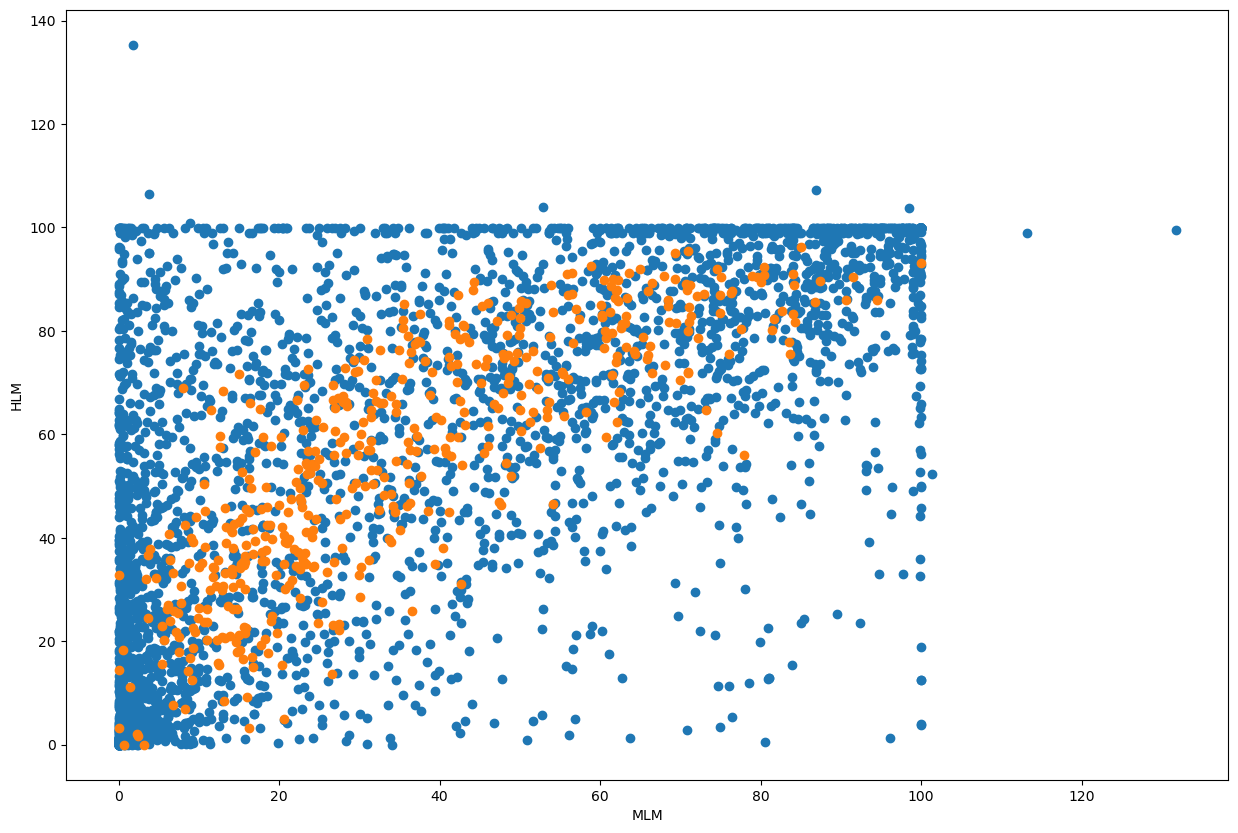

In [147]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
train = pd.read_csv('./train.csv')
plt.scatter(train['MLM'],train['HLM'])
plt.xlabel('MLM')
plt.ylabel('HLM')
plt.scatter(submission['MLM'],submission['HLM'])
plt.xlabel('MLM')
plt.ylabel('HLM')

In [146]:
submission = pd.read_csv('./Not_Optuna_mlm_50_hlm_44.csv')

submission.loc[submission[submission['MLM'] > 100].index,'MLM'] = 100
submission.loc[submission[submission['MLM'] < 0].index,'MLM'] = 0
submission.loc[submission[submission['HLM'] < 0].index,'HLM'] = 0
submission.to_csv('Not_Optuna_mlm_50_hlm_44_scale.csv', index=False)


In [116]:
hi_ = pd.read_csv('./Not_Optuna_mlm_50_hlm_44_.csv')
hi = pd.read_csv('./Not_Optuna_mlm_50_hlm_44.csv')
hi_

,id,MLM,HLM
0,TEST_000,27.638393,51.453808
1,TEST_001,67.297910,86.095566
2,TEST_002,21.858360,34.719765
3,TEST_003,51.427624,83.424065
4,TEST_004,65.127520,91.405470
...,...,...,...
478,TEST_478,2.376625,-3.278576
479,TEST_479,85.864780,99.998050
480,TEST_480,31.209686,78.592650
481,TEST_481,51.183617,76.877625


In [150]:
(26**2)/480

1.4083333333333334